Philippe Joly MAIS 202

This is an implementation of a Deep Neural Network (DNN) to predict Electrical Power Demand based on the Weather in Quebec

In [22]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import os
from dotenv import load_dotenv
load_dotenv()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATA

In [23]:
data = pd.read_csv(os.getenv("DATA"))
# data['Date/Time (UTC)'] = pd.to_datetime(data['Date/Time (UTC)'])
data.dropna(inplace=True)
data.drop(columns=['Date/Time (UTC)','Year'], inplace=True)
data = data.astype(float)

X_tot = data.drop(columns=["Average Power Output (MW)"]).values
y_tot = data["Average Power Output (MW)"].values

X, X_test, y, y_test = train_test_split(X_tot, y_tot, test_size=0.1, random_state=45)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=45)

In [24]:
print(f'Training set size: {X.shape[0]}')
print(f'Validation set size: {X_test.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Number of Features: {X.shape[1]}')
print(data.drop(columns=["Average Power Output (MW)"]).keys().values)

Training set size: 31514
Validation set size: 1751
Test set size: 1751
Number of Features: 6
['Temp (°C)' 'Month' 'Day' 'Hour' 'Day of Week' 'Population']


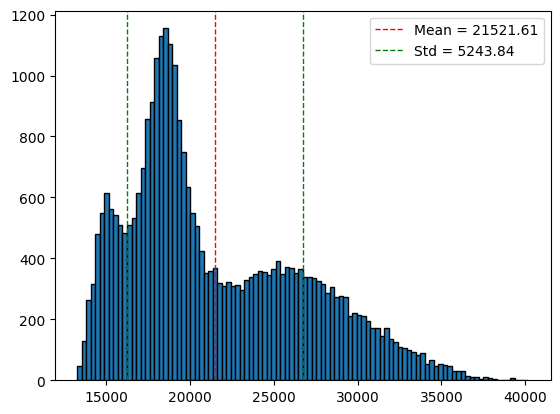

In [25]:
plt.hist(y, bins=100, edgecolor='black')
mean = np.mean(y)
std = np.std(y)

# Add mean and std to the plot
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean = {mean:.2f}')
plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1, label=f'Std = {std:.2f}')
plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

# MODEL

In [26]:
class neuralNet(nn.Module):
    def __init__(self, n_features, n_outs, hidden_size):
        super(neuralNet, self).__init__()
        self.to(device)

        self.l1 = nn.Linear(n_features, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.l5 = nn.Linear(hidden_size, hidden_size)
        self.l6 = nn.Linear(hidden_size, hidden_size)
        self.l7 = nn.Linear(hidden_size, n_outs)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.l1(X)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        out = self.relu(out)
        out = self.l6(out)
        out = self.relu(out)
        out = self.l7(out)
        return out
    
    def getScale(self,X,y):
        y = y.reshape(len(y), 1)

        self.x_scaler = StandardScaler().fit(X)
        self.y_scaler = StandardScaler().fit(y)

    def scaleX(self, X):
        return self.x_scaler.transform(X)
    
    def scaley(self, y):
        return self.y_scaler.transform(y.reshape(len(y),1))
    
    def unscaley(self,y):
        return self.y_scaler.inverse_transform(y).reshape(y.shape[0])

    def fit(self, X_train, y_train, X_val, y_val, num_epochs,batch_size, lr):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.train_losses = []
        self.val_losses = []
        self.it_ls = []

        self.getScale(X_train,y_train)
        X_train = torch.from_numpy(self.scaleX(X_train))
        y_train = torch.from_numpy(self.scaley(y_train))

        X_val = torch.from_numpy(self.scaleX(X_val)).to(torch.float32).to(device)
        y_val = torch.from_numpy(self.scaley(y_val)).to(torch.float32).to(device)

        train_load = torch.utils.data.TensorDataset(X_train,y_train)
        train_load = torch.utils.data.DataLoader(dataset=train_load, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for i, (X, y) in enumerate(train_load):
                self.it_ls.append(epoch*len(train_load)+i)
                X= X.to(torch.float32).to(device)
                y = y.to(torch.float32).to(device)
                
                outputs = self.forward(X)
                loss = criterion(outputs, y)
                self.train_losses.append(loss.item())

                with torch.no_grad():
                    val_outputs=self.forward(X_val)
                    self.val_losses.append(criterion(val_outputs, y_val).item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if(epoch*len(train_load)+i+1)%(num_epochs*len(train_load)//10)==0:
                    print(f'epoch: {epoch+1}/{num_epochs}, step {i+1}/{len(train_load)}, loss = {loss.item():.4f}')
    
    def train_score(self):
        print(f'Training Loss: {self.train_losses[-1]:.4f}')
        print(f'Validation Loss: {self.val_losses[-1]:.4f}')

        plt.plot(self.it_ls, self.train_losses, color="blue", label="Training Loss")
        plt.plot(self.it_ls, self.val_losses, color="red", label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("MSE")
        plt.title("Training and Validation MSE")
        plt.legend()
        plt.show()

    def test_score(self, X_test, y_test):
        with torch.no_grad():
            X_test = self.scaleX(X_test)
            outputs = self.forward(torch.from_numpy(X_test).to(torch.float32).to(device)).to('cpu').detach().numpy()
            y_pred = self.unscaley(outputs)

            print(f'MSE: {mean_squared_error(y_test, y_pred)}')
            print(f'R2: {r2_score(y_test, y_pred)}')
            print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

    def save_model(self, name):
        time = dt.now().strftime("%y-%m-%d_%H-%M")
        f = f"../trainedModels/{name}_{time}.pth"
        torch.save(self.state_dict(), f)

# Training & Testing

In [27]:
model = neuralNet(n_features=X.shape[1], n_outs=1,hidden_sizes=10)

In [28]:
model.fit(X_train=X, y_train=y, X_val=X_val, y_val=y_val, num_epochs=2000, batch_size=(X.shape[0]//2), lr=0.01)

epoch: 200/2000, step 2/2, loss = 0.0481
epoch: 400/2000, step 2/2, loss = 0.0409
epoch: 600/2000, step 2/2, loss = 0.0398
epoch: 800/2000, step 2/2, loss = 0.0372
epoch: 1000/2000, step 2/2, loss = 0.0336
epoch: 1200/2000, step 2/2, loss = 0.0316
epoch: 1400/2000, step 2/2, loss = 0.0307
epoch: 1600/2000, step 2/2, loss = 0.0347
epoch: 1800/2000, step 2/2, loss = 0.0286
epoch: 2000/2000, step 2/2, loss = 0.0276


Training Loss: 0.0276
Validation Loss: 0.0290


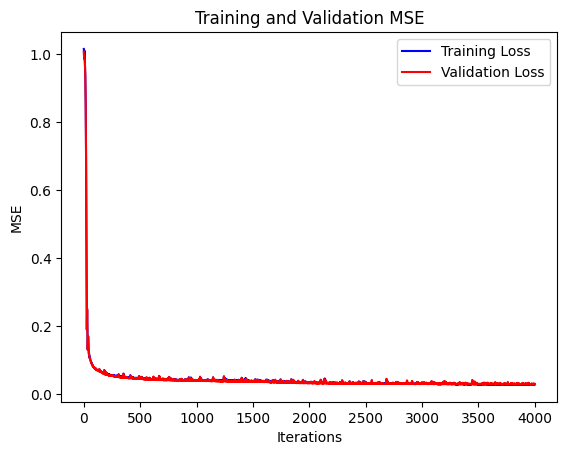

MSE: 778559.7034305162
R2: 0.9714917719845636
MAE: 656.7565044751213


In [29]:
model.eval()
model.train_score()
model.test_score(X_test=X_val, y_test=y_val)

In [30]:
model.save_model(f"../../trainedModels/dnn_5x5hid_relu_")

# Testing

In [34]:
f="../../trainedModels/dnn_5x5hid_relu__24-03-17_13-35.pth"
loaded_model = neuralNet(n_features=X.shape[1], n_outs=1,hidden_size=10)
loaded_model.load_state_dict(torch.load(f))
loaded_model.eval()

neuralNet(
  (l1): Linear(in_features=6, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=10, bias=True)
  (l3): Linear(in_features=10, out_features=10, bias=True)
  (l4): Linear(in_features=10, out_features=10, bias=True)
  (l5): Linear(in_features=10, out_features=10, bias=True)
  (l6): Linear(in_features=10, out_features=10, bias=True)
  (l7): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [35]:
X, X_test, y, y_test = train_test_split(X_tot, y_tot, test_size=0.1, random_state=45)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=45)

loaded_model.getScale(X, y)

In [36]:
loaded_model.test_score(X_test=X_test, y_test=y_test)

MSE: 807862.922924085
R2: 0.9705088964921949
MAE: 672.9456143141418
